In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121


In [3]:
disease_types = ['Potato___Early_blight','Potato___Late_blight','Potato___healthy']
data_dir = r'D:\plant\potato PlantVillage.csv'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
2147,Potato___healthy/f4be3632-42a1-415a-9f7e-1d5ec...,2,Potato___healthy
2148,Potato___healthy/f5bd2732-197b-4d8e-bb50-a4966...,2,Potato___healthy
2149,Potato___healthy/f66af6c0-6fc6-4020-b1de-a7368...,2,Potato___healthy
2150,Potato___healthy/fd92bd9c-02cb-4599-8673-93161...,2,Potato___healthy
2151,Potato___healthy/ff700844-68ad-4e99-8427-58a39...,2,Potato___healthy


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Potato___Late_blight/84f666da-9e17-4e90-9813-0...,1,Potato___Late_blight
1,Potato___Late_blight/ae966e38-73b3-47c1-9421-2...,1,Potato___Late_blight
2,Potato___Early_blight/e217c2fe-b0d5-45e6-a7fa-...,0,Potato___Early_blight
3,Potato___Early_blight/51d521bb-5800-4f46-8fd0-...,0,Potato___Early_blight
4,Potato___Late_blight/c8bfd67e-892e-4502-982a-a...,1,Potato___Late_blight


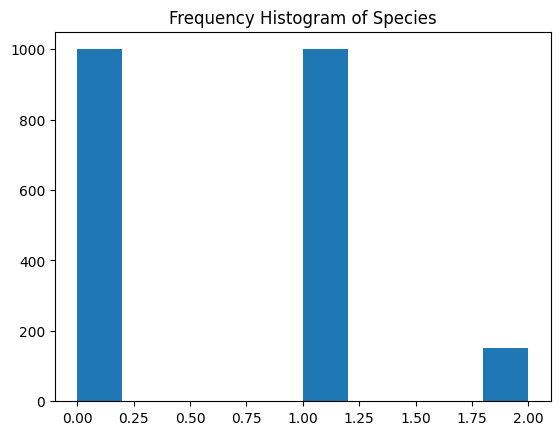

<Figure size 1200x1200 with 0 Axes>

In [6]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

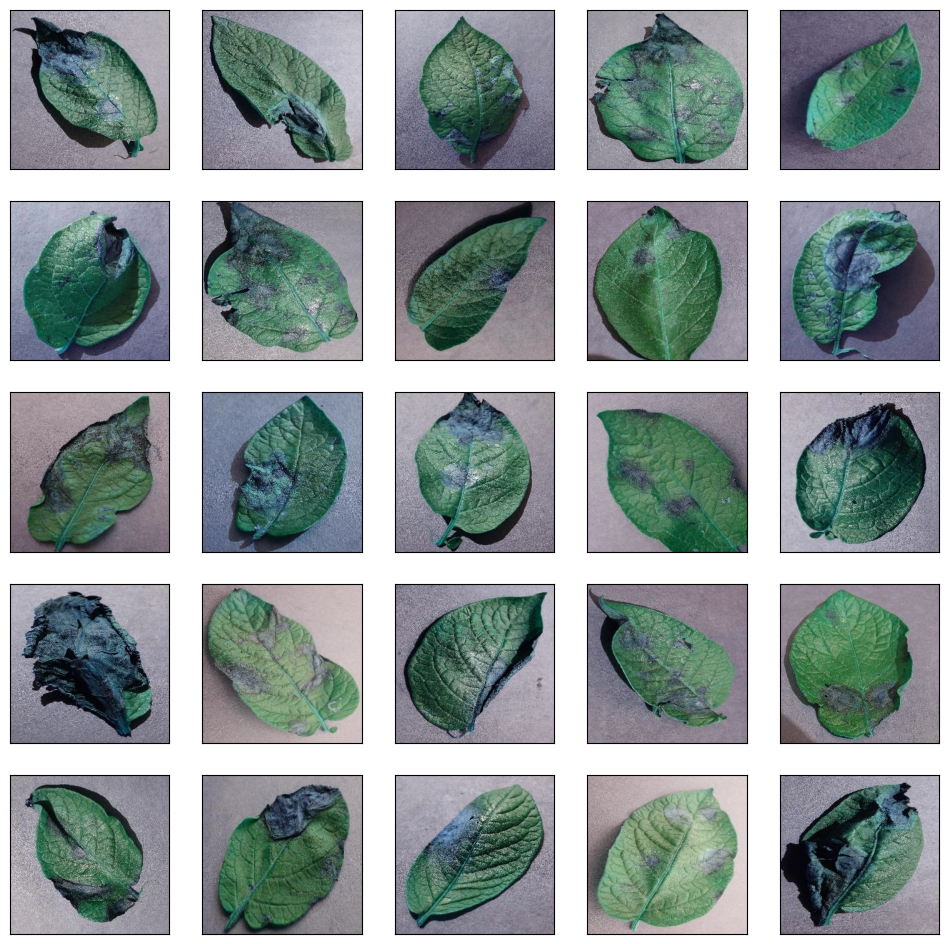

In [7]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Potato___Late_blight', 5, 5)

In [8]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))


2152it [00:27, 79.11it/s] 


Train Shape: (2152, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [11]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

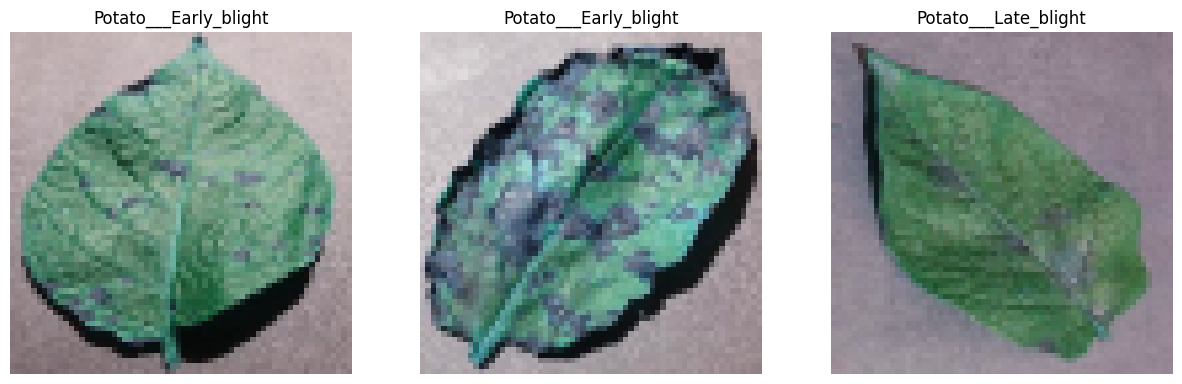

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [13]:
EPOCHS = 50
SIZE=64
N_ch=3

In [14]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
from keras.layers import Input 

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [17]:
import tensorflow as tf

model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=2,
                 callbacks=[annealer, checkpoint],
                 validation_data=(X_val, Y_val))




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                           

C:\Users\ankma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 160s - loss: 3.6394 - accuracy: 0.1298 - val_loss: 1.7648 - val_accuracy: 0.4617 - lr: 0.0020 - 160s/epoch - 6s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 1.76484
26/26 - 79s - loss: 2.5894 - accuracy: 0.3138 - val_loss: 1.8060 - val_accuracy: 0.5777 - lr: 0.0020 - 79s/epoch - 3s/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.76484
26/26 - 80s - loss: 1.4271 - accuracy: 0.6041 - val_loss: 4.2047 - val_accuracy: 0.5012 - lr: 0.0020 - 80s/epoch - 3s/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.76484
26/26 - 82s - loss: 0.9203 - accuracy: 0.7652 - val_loss: 4.8130 - val_accuracy: 0.4733 - lr: 0.0020 - 82s/epoch - 3s/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.76484
26/26 - 79s - loss: 0.5456 - accuracy: 0.8666 - val_loss: 5.7516 - val_accuracy: 0.4710 - lr: 0.0020 - 79s/epoch - 3s/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.76484
26/26 - 80s - loss: 0.3775 - accuracy: 0.9034 - val_loss: 8.0317 - val_accuracy: 0.4710 

In [18]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy)) 

14/14 [==============================] - 3s 209ms/step - loss: 0.0243 - accuracy: 0.9884
Final Loss: 0.024310274049639702, Final Accuracy: 0.988399088382721


14/14 [==============================] - 7s 205ms/step


Text(0.5, 192.58159722222217, 'Predicted')

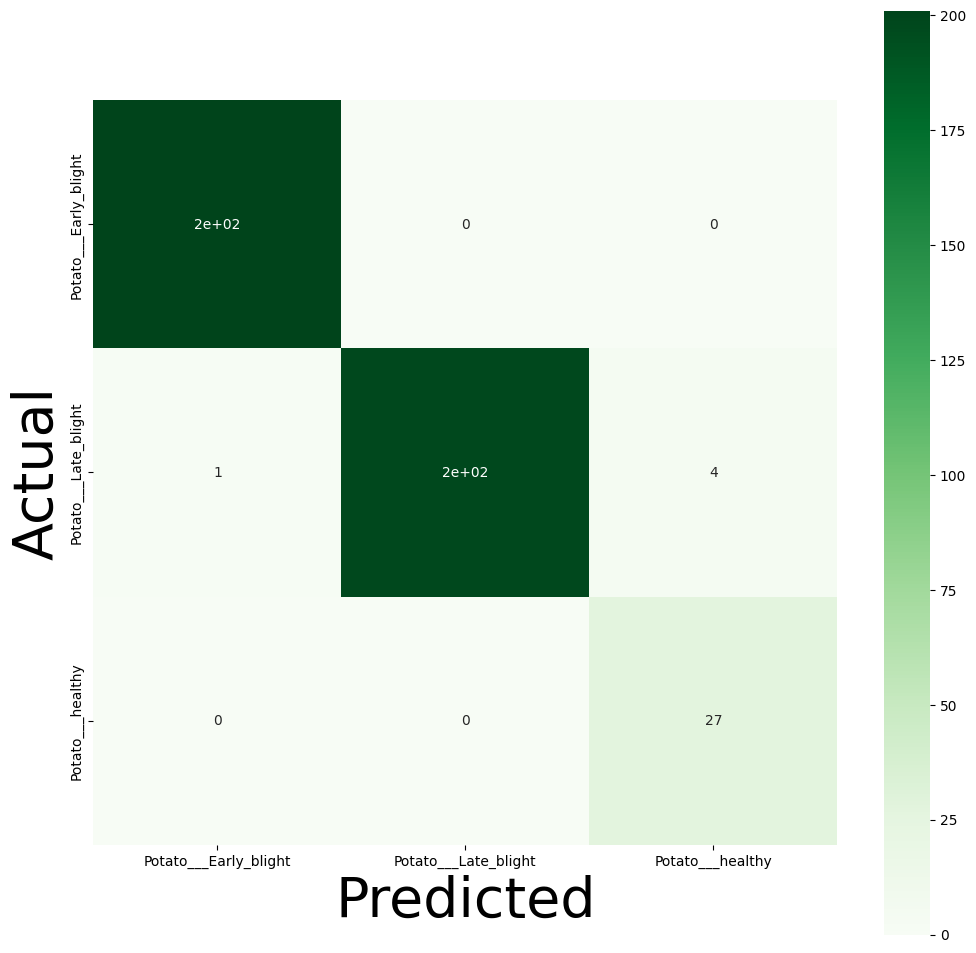

In [19]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

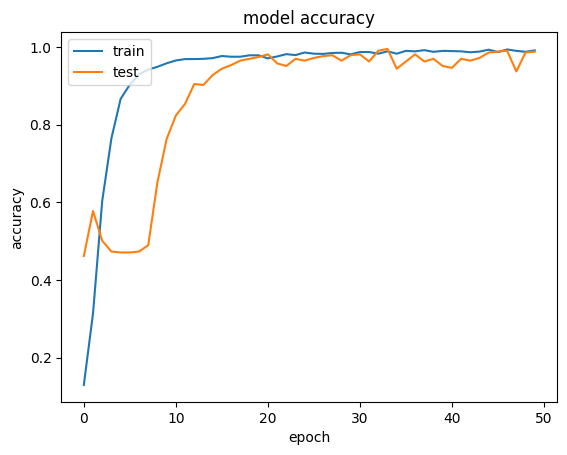

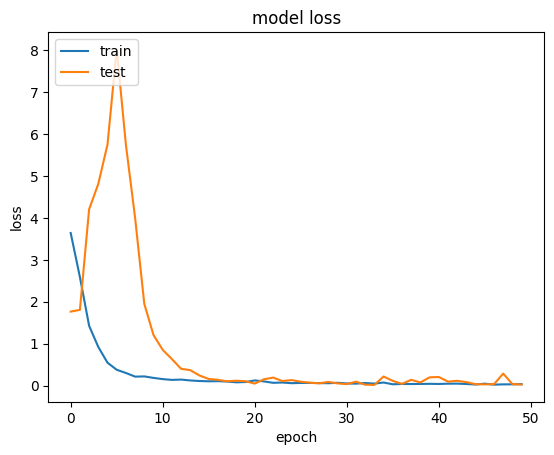

In [20]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 64ms/step
[8.87380362e-01 4.93595067e-14 1.06064625e-01 1.62775477e-03
 2.03848649e-05 3.21406405e-04 7.08810257e-05 4.28294261e-05
 4.45715013e-05 4.16577840e-03 5.33733437e-05 9.89688415e-05
 1.81132709e-05 2.83547761e-05 6.26177061e-05]


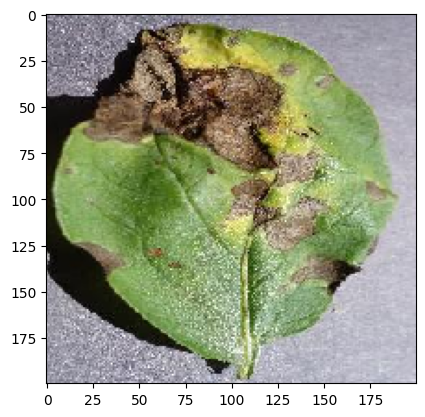

Prediction: Potato___Early_blight


In [26]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img(r'D:\plant\potato PlantVillage.csv\Potato___Early_blight\0e0a1b51-f61c-4934-bc57-a820af1faacb___RS_Early.B 7147.JPG', target_size=(64, 64))
show_img = image.load_img(r'D:\plant\potato PlantVillage.csv\Potato___Early_blight\0e0a1b51-f61c-4934-bc57-a820af1faacb___RS_Early.B 7147.JPG', target_size=(200, 200))


disease_class = ['Potato___Early_blight','Potato___Late_blight','Potato___healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])